In [1]:
from __future__ import division, print_function, absolute_import

# Import MNIST data
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("data/", one_hot=False)

import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from keras.datasets import mnist as mn
from keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot
from keras import backend as K
K.set_image_dim_ordering('th')

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting data/train-labels-idx1-ubyte.gz
Extracting data/t10k-images-idx3-ubyte.gz
Extracting data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


Using TensorFlow backend.


In [2]:
# Training Parameters
learning_rate = 0.01
num_steps = 500
batch_size = 128
n_images = 10000

# Network Parameters
num_input = 784 # MNIST data input (img shape: 28*28)
num_classes = 10 # MNIST total classes (0-9 digits)
dropout = 0.25 # Dropout, probability to drop a unit

In [3]:
# Create the neural network
def conv_net(x_dict, n_classes, dropout, reuse, is_training):
    
    # Define a scope for reusing the variables
    with tf.variable_scope('ConvNet', reuse=reuse):
        # TF Estimator input is a dict, in case of multiple inputs
        x = x_dict['images']

        # MNIST data input is a 1-D vector of 784 features (28*28 pixels)
        # Reshape to match picture format [Height x Width x Channel]
        # Tensor input become 4-D: [Batch Size, Height, Width, Channel]
        x = tf.reshape(x, shape=[-1, 28, 28, 1])

        # Convolution Layer with 32 filters 
        conv1 = tf.layers.conv2d(x, 32, 5, activation=tf.nn.relu)

        # Convolution Layer with 64 filters 
        conv2 = tf.layers.conv2d(conv1, 64, 3, activation=tf.nn.relu)

        # Flatten the data to a 1-D vector for the fully connected layer
        fc1 = tf.contrib.layers.flatten(conv2)

        # Fully connected layer (in tf contrib folder for now)
        fc1 = tf.layers.dense(fc1, 1024)
        # Apply Dropout (if is_training is False, dropout is not applied)
        fc1 = tf.layers.dropout(fc1, rate=dropout, training=is_training)

        # Output layer, class prediction
        out = tf.layers.dense(fc1, n_classes)

    return out


In [4]:
# Define the model function (following TF Estimator Template)
def model_fn(features, labels, mode):
    
    # Build the neural network
    # Because Dropout have different behavior at training and prediction time, we
    # need to create 2 distinct computation graphs that still share the same weights.
    logits_train = conv_net(features, num_classes, dropout, reuse=False, is_training=True)
    logits_test = conv_net(features, num_classes, dropout, reuse=True, is_training=False)
    
    # Predictions
    pred_classes = tf.argmax(logits_test, axis=1)
    pred_probas = tf.nn.softmax(logits_test)
    
    # If prediction mode, early return
    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode, predictions=pred_classes) 
        
    # Define loss and optimizer
    loss_op = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(
        logits=logits_train, labels=tf.cast(labels, dtype=tf.int32)))
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
    train_op = optimizer.minimize(loss_op, global_step=tf.train.get_global_step())
    
    # Evaluate the accuracy of the model
    acc_op = tf.metrics.accuracy(labels=labels, predictions=pred_classes)
    
    # TF Estimators requires to return a EstimatorSpec, that specify
    # the different ops for training, evaluating, ...
    estim_specs = tf.estimator.EstimatorSpec(
      mode=mode,
      predictions=pred_classes,
      loss=loss_op,
      train_op=train_op,
      eval_metric_ops={'accuracy': acc_op})

    return estim_specs

In [5]:
# Build the Estimator
model = tf.estimator.Estimator(model_fn)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/var/folders/33/cbwqx9c11lgfbcvwxr2yf6jm0000gn/T/tmpmkhfn_lz', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x1c3dc8d9e8>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [6]:
# Define the input function for training
X_tr={'images': mnist.train.images}
Y_tr=mnist.train.labels
input_fn = tf.estimator.inputs.numpy_input_fn(
    x=X_tr, y=Y_tr,
    batch_size=batch_size, num_epochs=None, shuffle=True)
# Train the Model
model.train(input_fn, steps=num_steps)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into /var/folders/33/cbwqx9c11lgfbcvwxr2yf6jm0000gn/T/tmpmkhfn_lz/model.ckpt.
INFO:tensorflow:loss = 2.3157463, step = 1
INFO:tensorflow:global_step/sec: 1.11211
INFO:tensorflow:loss = 0.64334935, step = 101 (89.920 sec)
INFO:tensorflow:global_step/sec: 1.12037
INFO:tensorflow:loss = 0.57176757, step = 201 (89.262 sec)
INFO:tensorflow:global_step/sec: 1.17966
INFO:tensorflow:loss = 0.4466303, step = 301 (84.764 sec)
INFO:tensorflow:global_step/sec: 1.17633
INFO:tensorflow:loss = 0.44232997, step = 401 (85.013 sec)
INFO:tensorflow:Saving checkpoints for 500 into /var/folders/33/cbwqx9c11lgfbcvwxr2yf6jm0000gn/T/tmpmkhfn_lz/model.ckpt.
INFO:tensorflow:Loss for final step: 0.41434798.


In [7]:
# Evaluate the Model
# Define the input function for evaluating
input_fn = tf.estimator.inputs.numpy_input_fn(
    x={'images': mnist.test.images}, y=mnist.test.labels,
    batch_size=batch_size, shuffle=False)
# Use the Estimator 'evaluate' method
model.evaluate(input_fn)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-11-28-05:27:21
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/33/cbwqx9c11lgfbcvwxr2yf6jm0000gn/T/tmpmkhfn_lz/model.ckpt-500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-11-28-05:27:31
INFO:tensorflow:Saving dict for global step 500: accuracy = 0.7842, global_step = 500, loss = 0.5907741
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 500: /var/folders/33/cbwqx9c11lgfbcvwxr2yf6jm0000gn/T/tmpmkhfn_lz/model.ckpt-500


{'accuracy': 0.7842, 'loss': 0.5907741, 'global_step': 500}

In [8]:
write = 1
if write==1:
    f = open("results/shade.txt", 'w')

# Predict single images
# Get images from test set
test_images = mnist.test.images[:n_images]
test_label=mnist.test.labels[:n_images]

# # reshape to be [samples][pixels][width][height]
X_test = test_images
y_test = test_label
X_test = X_test.reshape(X_test.shape[0], 1, 28, 28)
# # convert from int to float
X_test = X_test.astype('float32')

X_test_backup = X_test
Y_test_backup = y_test

yBackup = []
pBackup = []
accMat = []


In [9]:
val = 0.01
for j in range(0,100):
    X_test = X_test_backup
    y_test = Y_test_backup
    mValue = val*j
    Xnew = [[[[v-mValue if v-mValue>0.0 else 0.0 for v in n] for n in x[0]]] for x in X_test]
    X_test = np.array(Xnew)
    X_test = X_test.astype('float32')
    # Prepare the input data
    input_fn = tf.estimator.inputs.numpy_input_fn(
        x={'images': X_test}, shuffle=False)
    # Use the model to predict the images class
    preds = list(model.predict(input_fn))

    accuracy = 0.0

    # Display
    for i in range(n_images):
#         plt.imshow(np.reshape(X_test[i], [28, 28]), cmap='gray')
#         plt.show()
        if (preds[i] == y_test[i]):
            accuracy = accuracy + 1/n_images
#         print("Model prediction:", preds[i], "  Correct value:", y_test[i])
    print("Accuracy is: ", accuracy)
    print("Step number: ", j)
    yBackup.append(y_test)
    pBackup.append(preds)
    accMat.append(accuracy)
    if write==1:
        f.write(str(mValue)+"\t"+str(accuracy)+"\n")
    
if write==1:
    f.close()
print("Done!")

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/33/cbwqx9c11lgfbcvwxr2yf6jm0000gn/T/tmpmkhfn_lz/model.ckpt-500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Accuracy is:  0.78419999999993
Step number:  0
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/33/cbwqx9c11lgfbcvwxr2yf6jm0000gn/T/tmpmkhfn_lz/model.ckpt-500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Accuracy is:  0.78389999999993
Step number:  1
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/33/cbwqx9c11lgfbcvwxr2yf6jm0000gn/T/tmpmkhfn_lz/model.ckpt-500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:D

Accuracy is:  0.7339999999999355
Step number:  22
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/33/cbwqx9c11lgfbcvwxr2yf6jm0000gn/T/tmpmkhfn_lz/model.ckpt-500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Accuracy is:  0.729199999999936
Step number:  23
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/33/cbwqx9c11lgfbcvwxr2yf6jm0000gn/T/tmpmkhfn_lz/model.ckpt-500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Accuracy is:  0.7249999999999365
Step number:  24
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/33/cbwqx9c11lgfbcvwxr2yf6jm0000gn/T/tmpmkhfn_lz/model.ckpt-500
I

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Accuracy is:  0.5958999999999507
Step number:  45
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/33/cbwqx9c11lgfbcvwxr2yf6jm0000gn/T/tmpmkhfn_lz/model.ckpt-500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Accuracy is:  0.5883999999999515
Step number:  46
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/33/cbwqx9c11lgfbcvwxr2yf6jm0000gn/T/tmpmkhfn_lz/model.ckpt-500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Accuracy is:  0.5790999999999525
Step number:  47
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameter

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Accuracy is:  0.3270999999999803
Step number:  68
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/33/cbwqx9c11lgfbcvwxr2yf6jm0000gn/T/tmpmkhfn_lz/model.ckpt-500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Accuracy is:  0.31029999999998215
Step number:  69
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/33/cbwqx9c11lgfbcvwxr2yf6jm0000gn/T/tmpmkhfn_lz/model.ckpt-500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Accuracy is:  0.293399999999984
Step number:  70
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameter

INFO:tensorflow:Restoring parameters from /var/folders/33/cbwqx9c11lgfbcvwxr2yf6jm0000gn/T/tmpmkhfn_lz/model.ckpt-500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Accuracy is:  0.10000000000000184
Step number:  91
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/33/cbwqx9c11lgfbcvwxr2yf6jm0000gn/T/tmpmkhfn_lz/model.ckpt-500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Accuracy is:  0.10000000000000184
Step number:  92
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/33/cbwqx9c11lgfbcvwxr2yf6jm0000gn/T/tmpmkhfn_lz/model.ckpt-500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Accuracy is:  0.10000000000000184
Step number:  93
INFO:tensorflow:Calling 

In [10]:
yTotal = [0]*10

for y in y_test:
    yTotal[y] = yTotal[y]+1

aMatrix = []
for i in range(len(pBackup)):
    print("\n\nYmatrix for rotation %d"%(i))
    yMatrix = [[0]*10 for i in range(10)]
    for j in range(len(pBackup[i])):
        yMatrix[yBackup[i][j]][pBackup[i][j]] += 1

    sum = 0
    
    for x in range(len(yMatrix)):
        for y in range(len(yMatrix[x])):
            yMatrix[x][y] = round(yMatrix[x][y]/yTotal[x], 3)

    aMatrix.append(yMatrix)
    for x in yMatrix:
        for y in x:
            print("%f" % (y),end=" ")
        print()
    



Ymatrix for rotation 0
0.709000 0.001000 0.014000 0.023000 0.002000 0.003000 0.229000 0.000000 0.019000 0.000000 
0.007000 0.933000 0.000000 0.037000 0.002000 0.001000 0.018000 0.000000 0.002000 0.000000 
0.018000 0.000000 0.690000 0.005000 0.056000 0.003000 0.220000 0.000000 0.008000 0.000000 
0.029000 0.006000 0.004000 0.764000 0.013000 0.001000 0.173000 0.000000 0.008000 0.002000 
0.001000 0.001000 0.152000 0.037000 0.440000 0.000000 0.358000 0.002000 0.009000 0.000000 
0.003000 0.001000 0.002000 0.002000 0.000000 0.871000 0.000000 0.083000 0.006000 0.032000 
0.108000 0.002000 0.122000 0.013000 0.038000 0.005000 0.678000 0.002000 0.031000 0.001000 
0.000000 0.000000 0.000000 0.000000 0.000000 0.022000 0.000000 0.903000 0.000000 0.075000 
0.004000 0.003000 0.015000 0.005000 0.005000 0.015000 0.038000 0.008000 0.905000 0.002000 
0.000000 0.001000 0.000000 0.000000 0.001000 0.006000 0.000000 0.043000 0.000000 0.949000 


Ymatrix for rotation 1
0.711000 0.001000 0.014000 0.023000 0.00

0.689000 0.006000 0.010000 0.023000 0.002000 0.034000 0.217000 0.000000 0.019000 0.000000 
0.007000 0.934000 0.000000 0.035000 0.002000 0.004000 0.017000 0.000000 0.001000 0.000000 
0.022000 0.002000 0.645000 0.010000 0.040000 0.022000 0.247000 0.000000 0.012000 0.000000 
0.038000 0.011000 0.006000 0.751000 0.011000 0.012000 0.162000 0.001000 0.008000 0.000000 
0.001000 0.002000 0.140000 0.035000 0.365000 0.018000 0.425000 0.002000 0.012000 0.000000 
0.002000 0.001000 0.001000 0.003000 0.000000 0.897000 0.000000 0.069000 0.004000 0.023000 
0.107000 0.003000 0.105000 0.014000 0.029000 0.050000 0.660000 0.002000 0.029000 0.001000 
0.000000 0.000000 0.000000 0.000000 0.000000 0.047000 0.000000 0.892000 0.000000 0.061000 
0.004000 0.003000 0.013000 0.004000 0.004000 0.034000 0.038000 0.012000 0.885000 0.003000 
0.000000 0.001000 0.000000 0.000000 0.001000 0.020000 0.001000 0.050000 0.000000 0.927000 


Ymatrix for rotation 14
0.684000 0.006000 0.009000 0.023000 0.002000 0.038000 0.218000 0

0.005000 0.909000 0.000000 0.035000 0.002000 0.032000 0.016000 0.001000 0.000000 0.000000 
0.022000 0.007000 0.519000 0.006000 0.023000 0.130000 0.277000 0.003000 0.013000 0.000000 
0.039000 0.009000 0.003000 0.713000 0.004000 0.065000 0.149000 0.002000 0.016000 0.000000 
0.000000 0.001000 0.137000 0.034000 0.261000 0.067000 0.474000 0.002000 0.024000 0.000000 
0.000000 0.001000 0.001000 0.003000 0.000000 0.922000 0.000000 0.052000 0.002000 0.019000 
0.105000 0.002000 0.076000 0.020000 0.019000 0.156000 0.581000 0.002000 0.039000 0.000000 
0.000000 0.000000 0.000000 0.000000 0.000000 0.103000 0.000000 0.841000 0.000000 0.056000 
0.005000 0.004000 0.012000 0.004000 0.003000 0.092000 0.034000 0.011000 0.832000 0.003000 
0.000000 0.001000 0.000000 0.000000 0.001000 0.055000 0.002000 0.043000 0.004000 0.894000 


Ymatrix for rotation 28
0.616000 0.007000 0.010000 0.024000 0.001000 0.119000 0.200000 0.003000 0.020000 0.000000 
0.006000 0.905000 0.000000 0.035000 0.002000 0.035000 0.016000 0

0.012000 0.008000 0.404000 0.005000 0.013000 0.280000 0.262000 0.001000 0.015000 0.000000 
0.035000 0.009000 0.003000 0.651000 0.000000 0.143000 0.138000 0.004000 0.017000 0.000000 
0.003000 0.003000 0.137000 0.032000 0.153000 0.116000 0.512000 0.002000 0.042000 0.000000 
0.000000 0.000000 0.000000 0.001000 0.000000 0.944000 0.000000 0.038000 0.000000 0.017000 
0.084000 0.003000 0.058000 0.016000 0.009000 0.310000 0.484000 0.001000 0.035000 0.000000 
0.000000 0.000000 0.000000 0.000000 0.000000 0.208000 0.000000 0.738000 0.000000 0.054000 
0.002000 0.002000 0.009000 0.004000 0.000000 0.198000 0.033000 0.010000 0.740000 0.002000 
0.001000 0.002000 0.000000 0.000000 0.001000 0.126000 0.002000 0.056000 0.008000 0.804000 


Ymatrix for rotation 42
0.521000 0.004000 0.008000 0.023000 0.000000 0.236000 0.187000 0.000000 0.021000 0.000000 
0.007000 0.802000 0.001000 0.034000 0.001000 0.137000 0.017000 0.001000 0.000000 0.000000 
0.014000 0.005000 0.398000 0.006000 0.013000 0.286000 0.262000 0

0.001000 0.002000 0.120000 0.029000 0.065000 0.230000 0.500000 0.000000 0.053000 0.000000 
0.000000 0.000000 0.000000 0.000000 0.000000 0.975000 0.001000 0.014000 0.000000 0.010000 
0.059000 0.001000 0.032000 0.014000 0.007000 0.505000 0.353000 0.000000 0.029000 0.000000 
0.000000 0.000000 0.000000 0.000000 0.000000 0.439000 0.000000 0.520000 0.000000 0.041000 
0.004000 0.002000 0.004000 0.003000 0.000000 0.363000 0.028000 0.008000 0.588000 0.000000 
0.000000 0.002000 0.000000 0.002000 0.001000 0.313000 0.005000 0.068000 0.015000 0.594000 


Ymatrix for rotation 56
0.411000 0.001000 0.004000 0.020000 0.000000 0.378000 0.161000 0.000000 0.025000 0.000000 
0.010000 0.641000 0.000000 0.036000 0.001000 0.301000 0.011000 0.000000 0.000000 0.000000 
0.009000 0.004000 0.273000 0.004000 0.007000 0.452000 0.229000 0.001000 0.021000 0.000000 
0.030000 0.006000 0.003000 0.523000 0.000000 0.318000 0.101000 0.004000 0.015000 0.000000 
0.001000 0.002000 0.115000 0.027000 0.064000 0.248000 0.490000 0

0.000000 0.000000 0.000000 0.001000 0.000000 0.994000 0.000000 0.001000 0.000000 0.004000 
0.044000 0.001000 0.016000 0.011000 0.005000 0.690000 0.209000 0.000000 0.024000 0.000000 
0.000000 0.000000 0.000000 0.000000 0.000000 0.842000 0.000000 0.153000 0.000000 0.005000 
0.000000 0.000000 0.001000 0.002000 0.000000 0.688000 0.013000 0.001000 0.295000 0.000000 
0.000000 0.001000 0.001000 0.003000 0.000000 0.692000 0.003000 0.057000 0.008000 0.235000 


Ymatrix for rotation 70
0.271000 0.001000 0.000000 0.013000 0.000000 0.600000 0.101000 0.000000 0.014000 0.000000 
0.008000 0.385000 0.000000 0.033000 0.001000 0.565000 0.008000 0.000000 0.000000 0.000000 
0.010000 0.003000 0.134000 0.001000 0.003000 0.645000 0.185000 0.000000 0.019000 0.000000 
0.021000 0.001000 0.000000 0.356000 0.000000 0.540000 0.066000 0.002000 0.014000 0.000000 
0.004000 0.002000 0.070000 0.015000 0.015000 0.520000 0.310000 0.000000 0.064000 0.000000 
0.000000 0.000000 0.000000 0.001000 0.000000 0.994000 0.000000 0

0.000000 0.000000 0.000000 0.000000 0.000000 0.999000 0.000000 0.001000 0.000000 0.000000 
0.000000 0.000000 0.000000 0.000000 0.000000 0.993000 0.001000 0.000000 0.006000 0.000000 
0.000000 0.000000 0.000000 0.001000 0.000000 0.998000 0.000000 0.000000 0.000000 0.001000 


Ymatrix for rotation 84
0.034000 0.000000 0.000000 0.000000 0.000000 0.958000 0.007000 0.000000 0.001000 0.000000 
0.002000 0.032000 0.000000 0.005000 0.000000 0.961000 0.000000 0.000000 0.000000 0.000000 
0.003000 0.000000 0.007000 0.000000 0.000000 0.960000 0.028000 0.000000 0.002000 0.000000 
0.002000 0.000000 0.000000 0.039000 0.000000 0.946000 0.013000 0.000000 0.000000 0.000000 
0.001000 0.000000 0.001000 0.003000 0.000000 0.972000 0.022000 0.000000 0.001000 0.000000 
0.000000 0.000000 0.000000 0.000000 0.000000 1.000000 0.000000 0.000000 0.000000 0.000000 
0.006000 0.000000 0.001000 0.001000 0.000000 0.980000 0.011000 0.000000 0.001000 0.000000 
0.000000 0.000000 0.000000 0.000000 0.000000 0.999000 0.000000 0

0.000000 0.000000 0.000000 0.000000 0.000000 1.000000 0.000000 0.000000 0.000000 0.000000 
0.000000 0.000000 0.000000 0.000000 0.000000 1.000000 0.000000 0.000000 0.000000 0.000000 
0.000000 0.000000 0.000000 0.000000 0.000000 1.000000 0.000000 0.000000 0.000000 0.000000 


Ymatrix for rotation 99
0.000000 0.000000 0.000000 0.000000 0.000000 1.000000 0.000000 0.000000 0.000000 0.000000 
0.000000 0.000000 0.000000 0.000000 0.000000 1.000000 0.000000 0.000000 0.000000 0.000000 
0.000000 0.000000 0.000000 0.000000 0.000000 1.000000 0.000000 0.000000 0.000000 0.000000 
0.000000 0.000000 0.000000 0.000000 0.000000 1.000000 0.000000 0.000000 0.000000 0.000000 
0.000000 0.000000 0.000000 0.000000 0.000000 1.000000 0.000000 0.000000 0.000000 0.000000 
0.000000 0.000000 0.000000 0.000000 0.000000 1.000000 0.000000 0.000000 0.000000 0.000000 
0.000000 0.000000 0.000000 0.000000 0.000000 1.000000 0.000000 0.000000 0.000000 0.000000 
0.000000 0.000000 0.000000 0.000000 0.000000 1.000000 0.000000 0

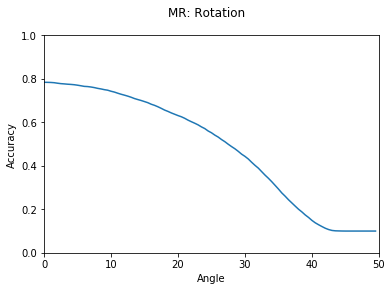

In [11]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
plt.axis([0, 50, 0, 1])
plt.plot(np.arange(0,50,0.5),accMat)
plt.xlabel("Angle")
plt.ylabel("Accuracy")
plt.suptitle("MR: Rotation")
plt.show()

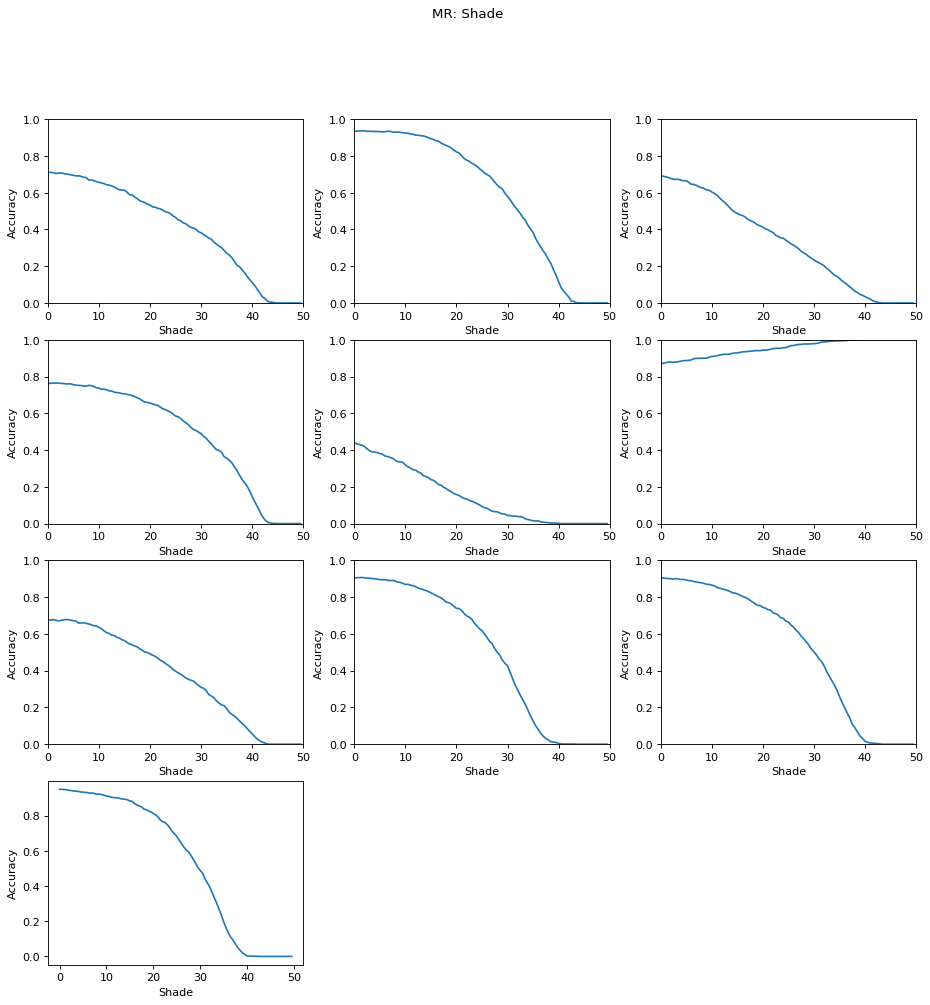

In [12]:

figure(num=None, figsize=(14, 14), dpi=80, facecolor='w', edgecolor='k')

zero = []
for j in range(10):
    zero = []
    for i in range(len(aMatrix)):
        zero.append(aMatrix[i][j][j])
    plt.axis([0, 50, 0, 1])
    plt.subplot(4,3,j+1)
    plt.plot(np.arange(0,50,0.5),zero)
    plt.xlabel("Shade")
    plt.ylabel("Accuracy")
plt.suptitle("MR: Shade")
plt.show()

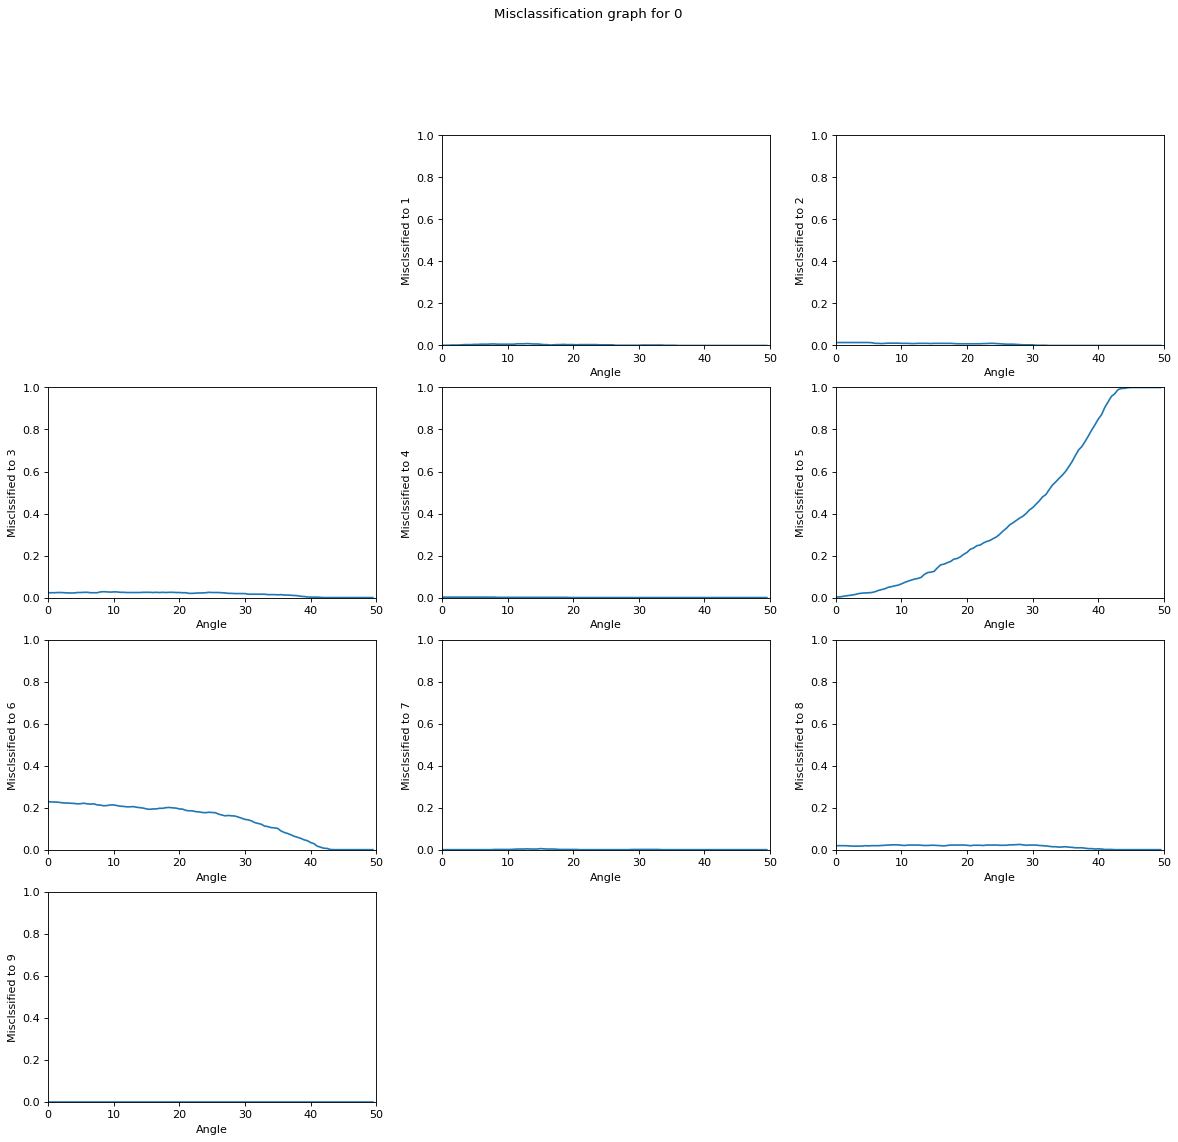

---------------------------------------------------------------------------------------------------------------------


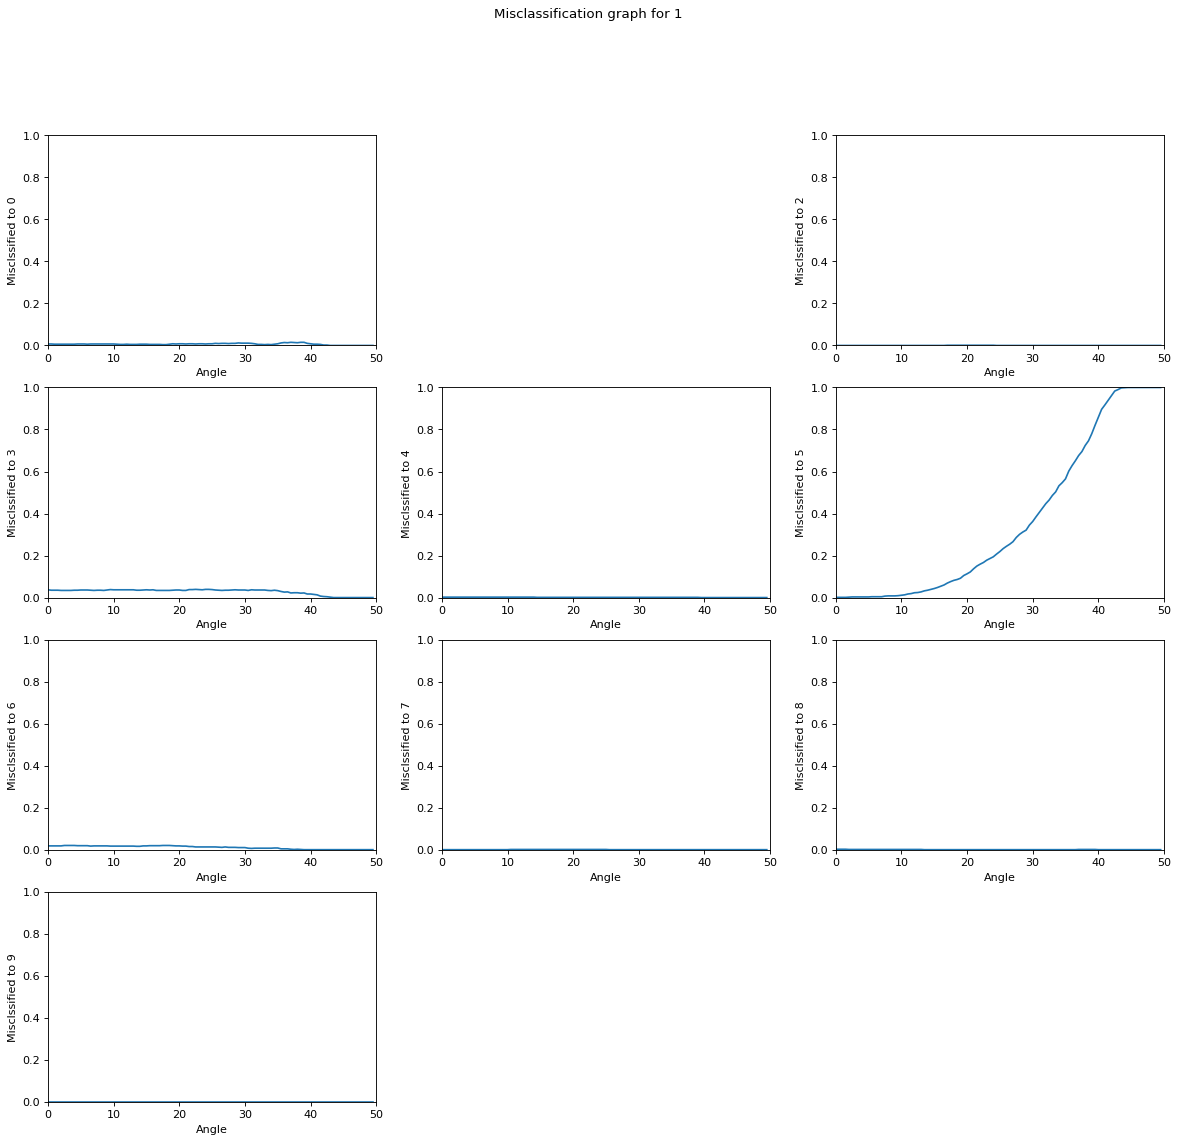

---------------------------------------------------------------------------------------------------------------------


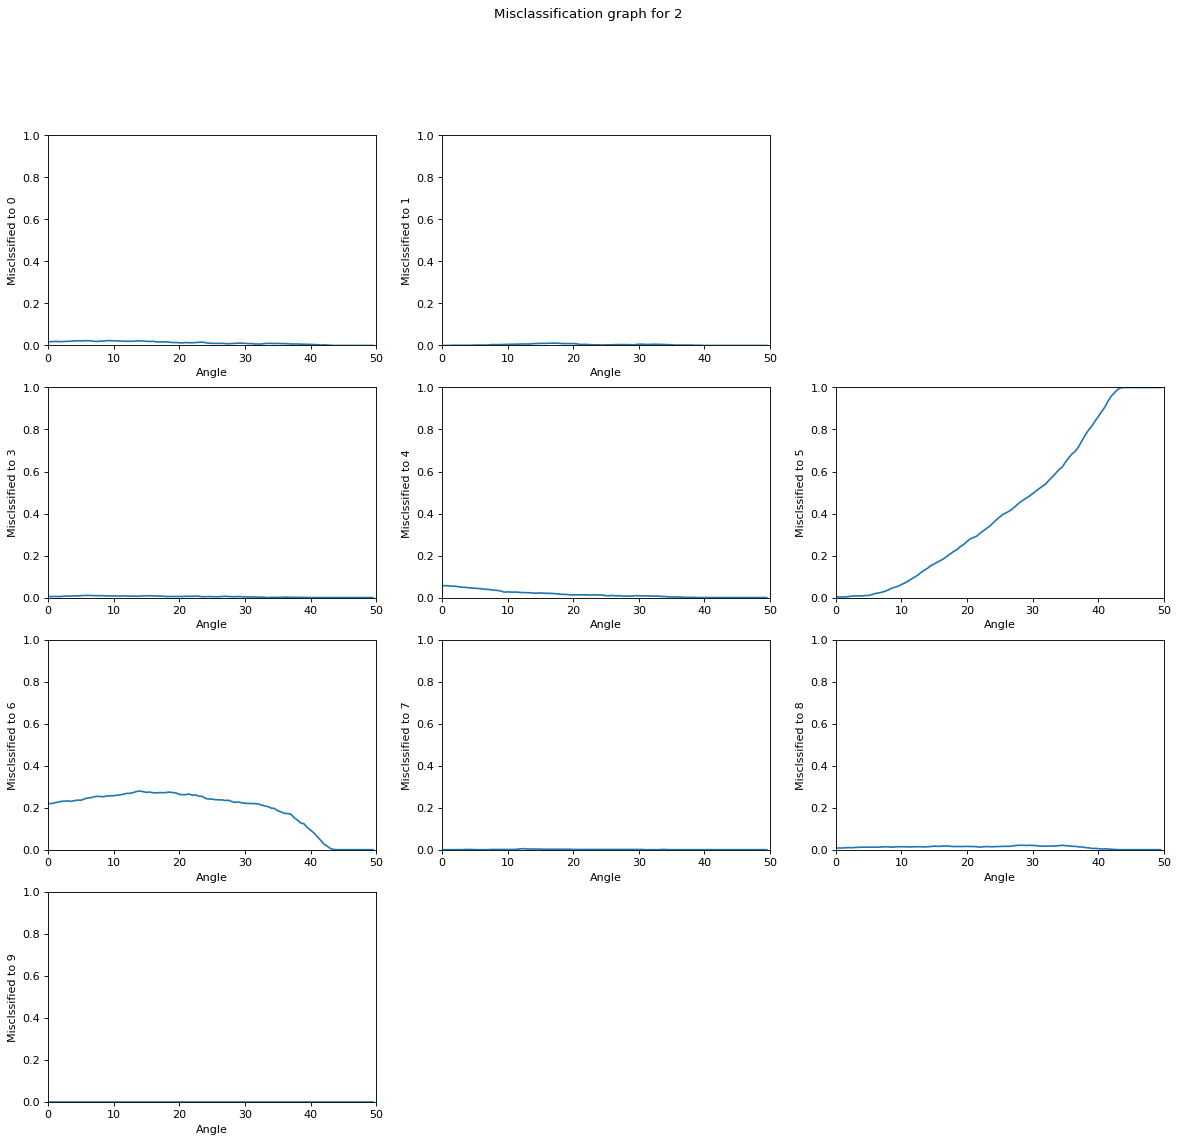

---------------------------------------------------------------------------------------------------------------------


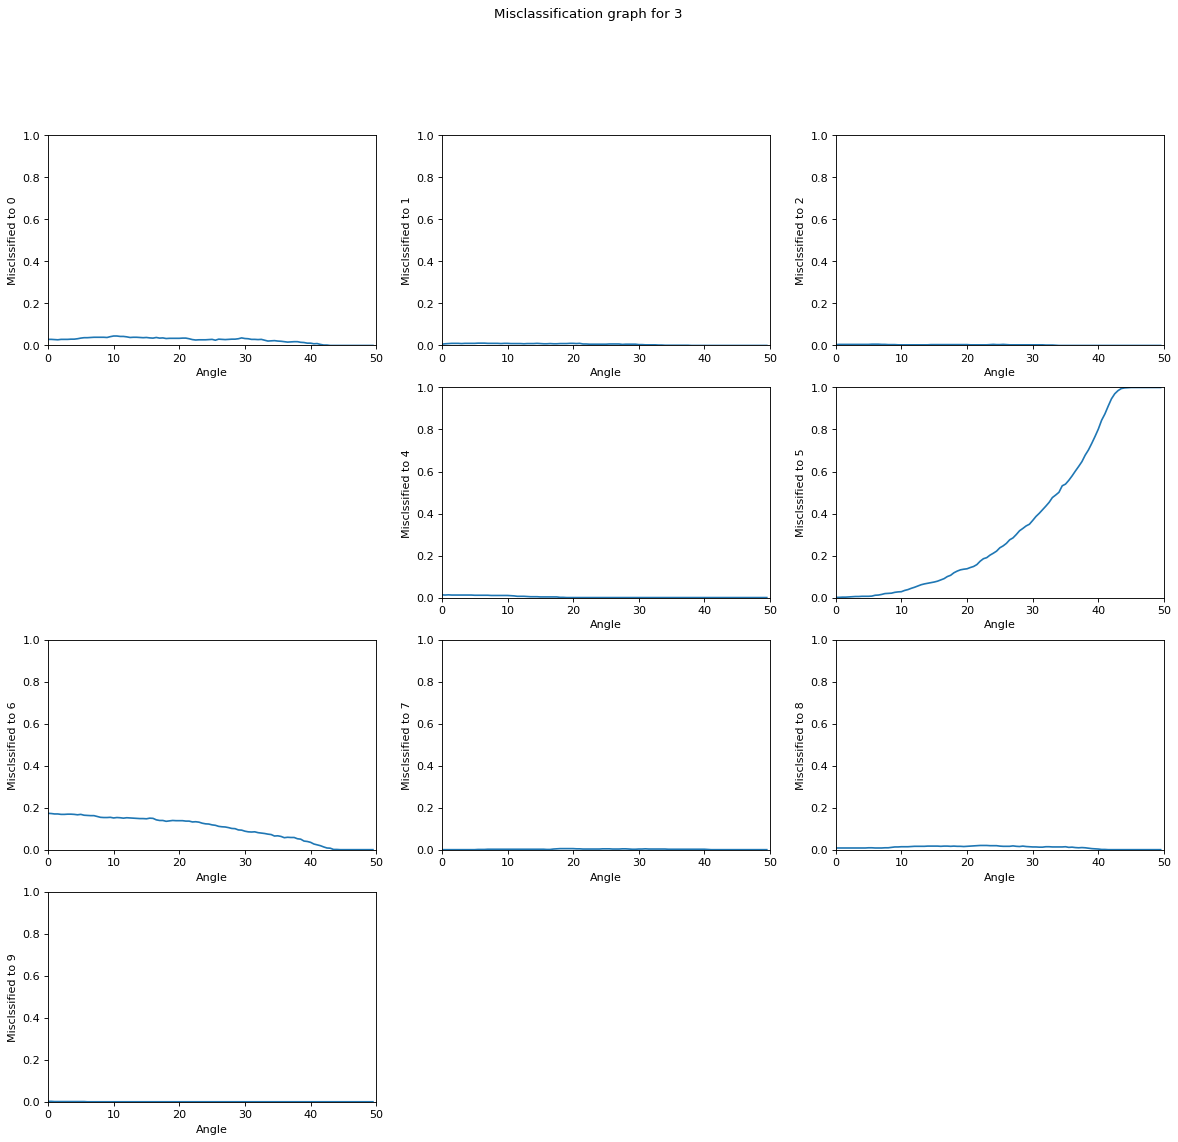

---------------------------------------------------------------------------------------------------------------------


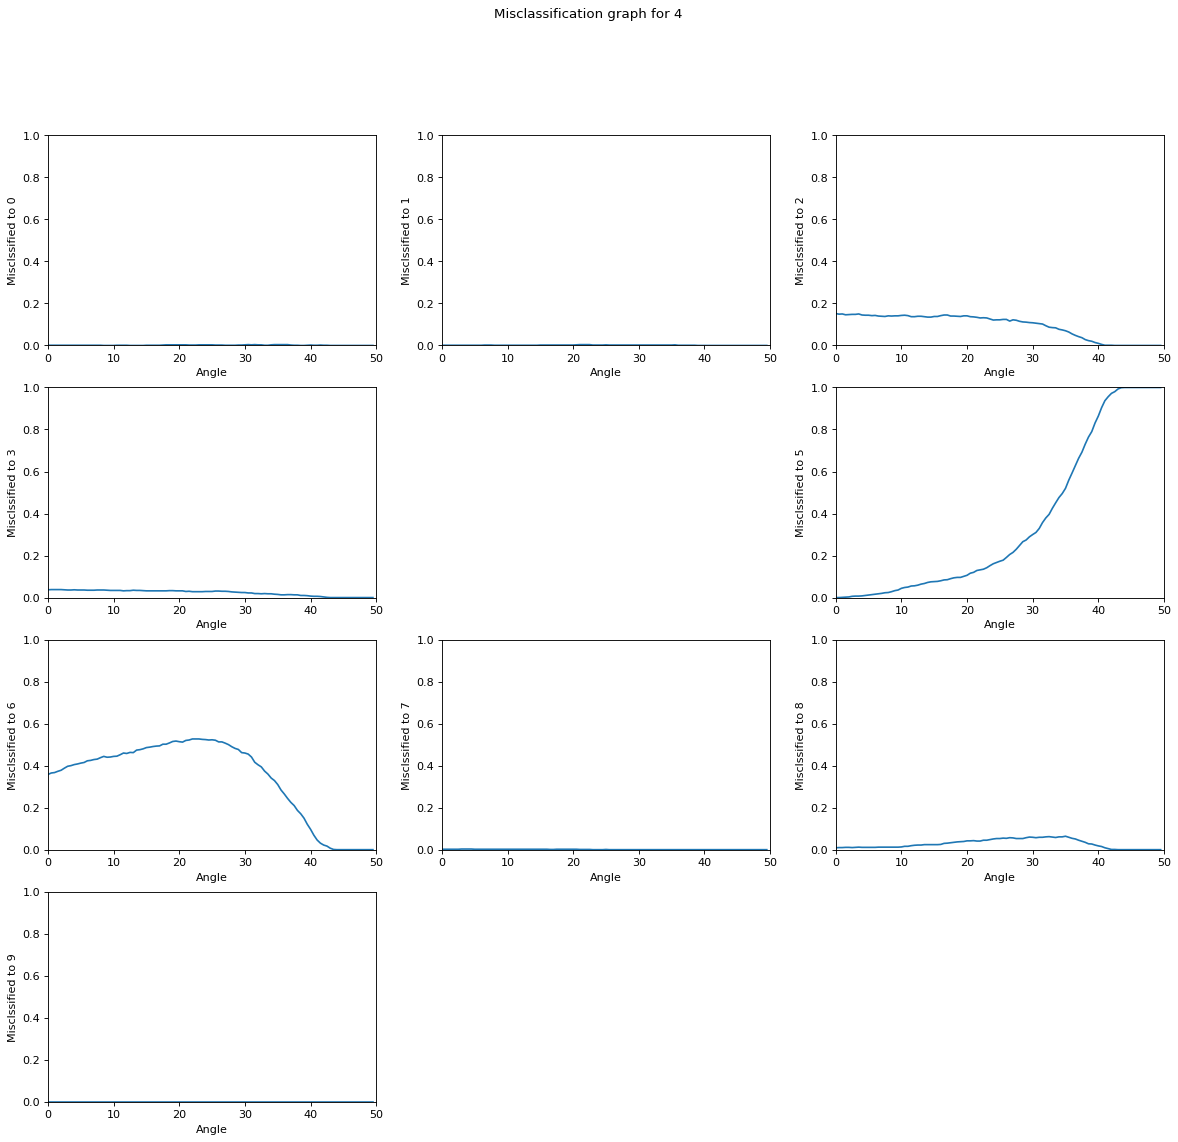

---------------------------------------------------------------------------------------------------------------------


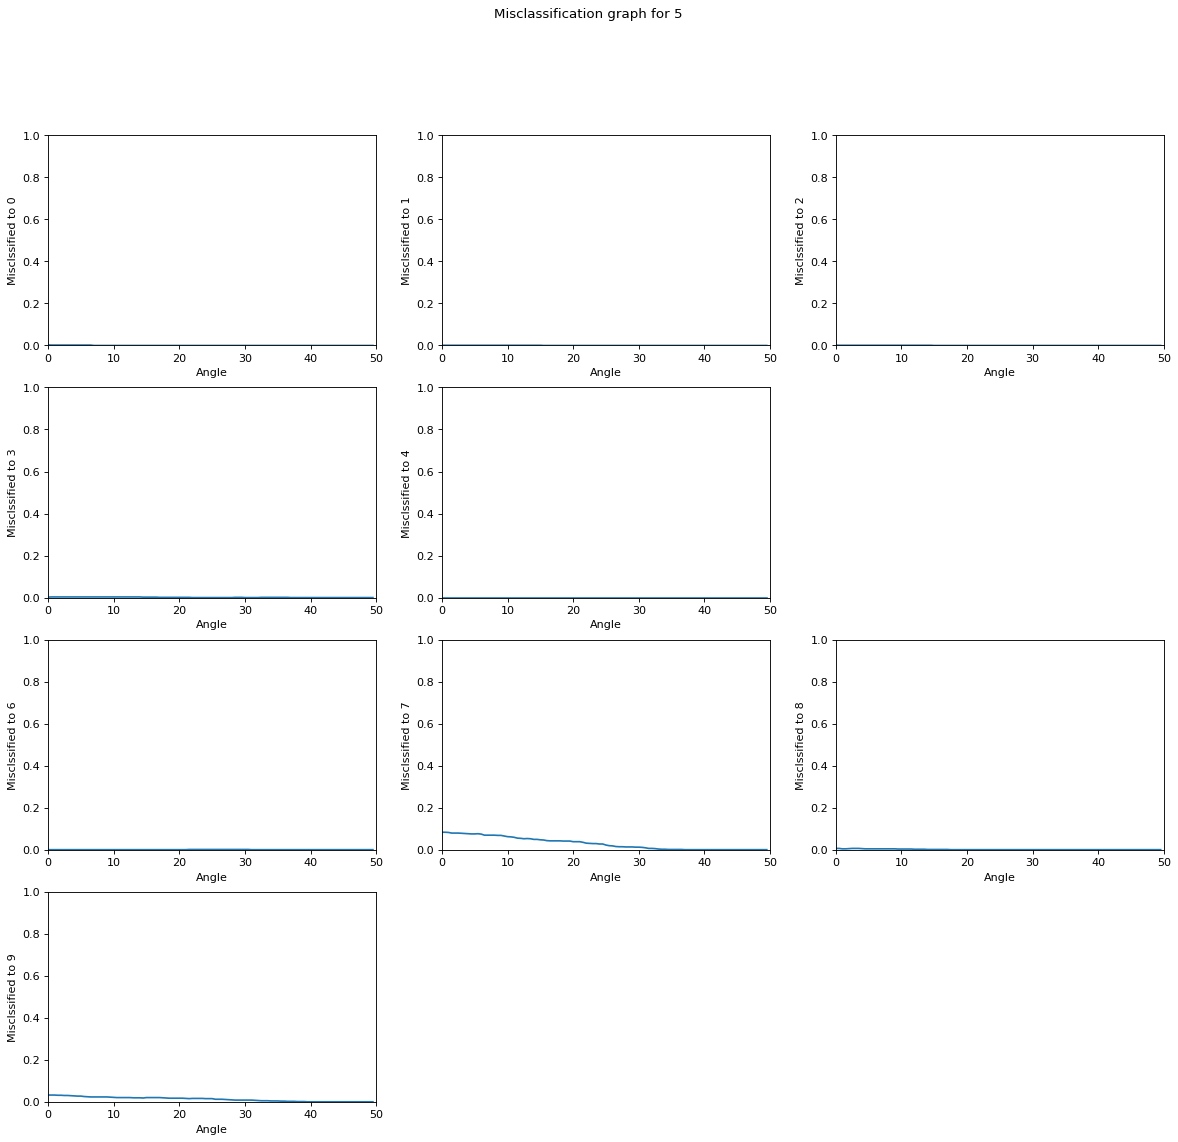

---------------------------------------------------------------------------------------------------------------------


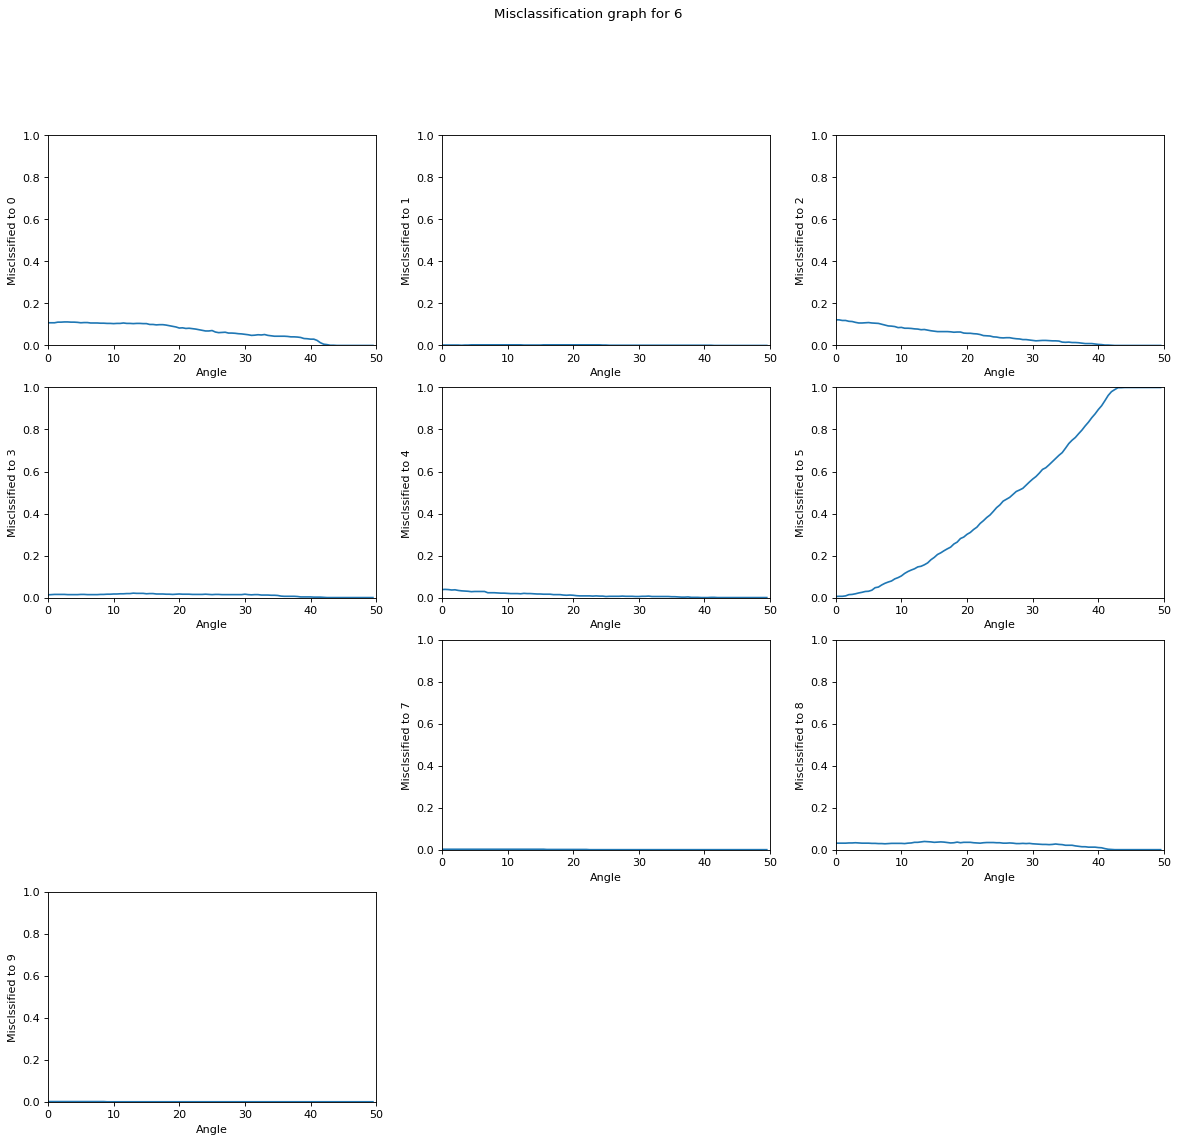

---------------------------------------------------------------------------------------------------------------------


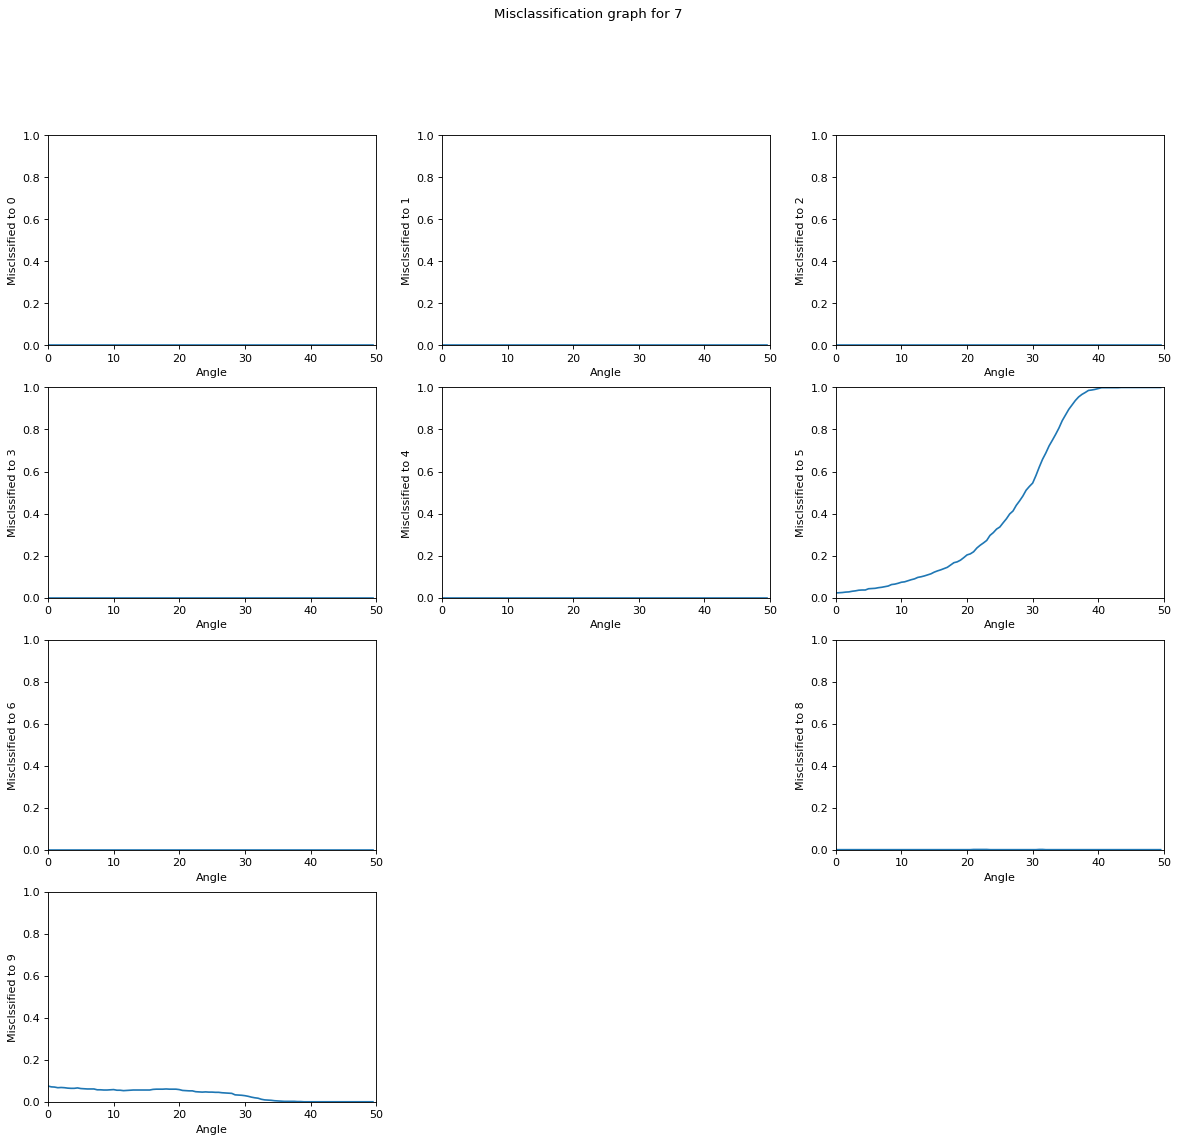

---------------------------------------------------------------------------------------------------------------------


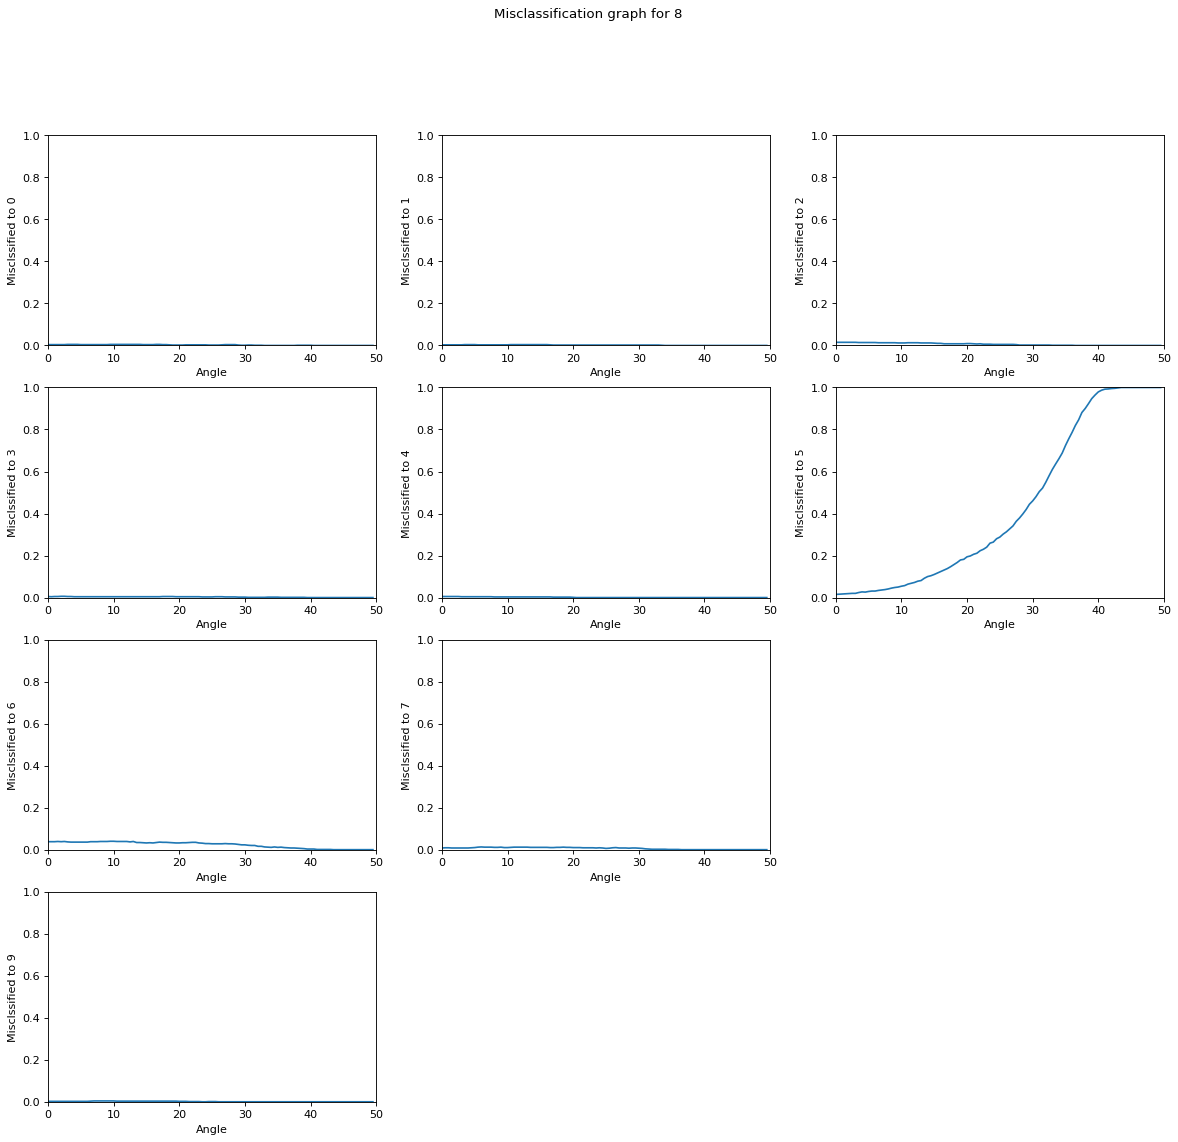

---------------------------------------------------------------------------------------------------------------------


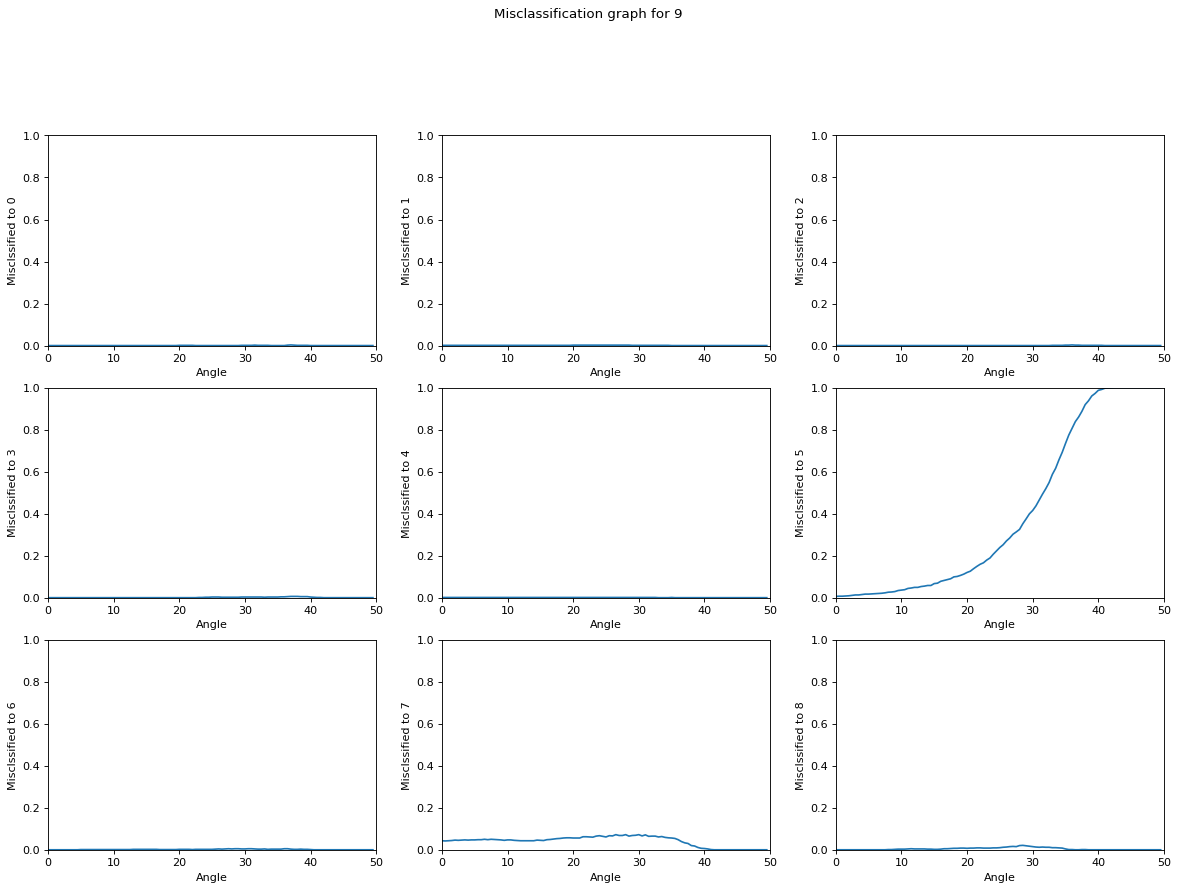

---------------------------------------------------------------------------------------------------------------------


In [13]:
zero = []

for j in range(10):
    figure(num=None, figsize=(18, 16), dpi=80, facecolor='w', edgecolor='k')
    for k in range(0,10):
        zero = []
        if j != k: 
            for i in range(len(aMatrix)):
                zero.append(aMatrix[i][j][k])
        else:
            continue       
        plt.subplot(4,3,k+1)
        plt.axis([0, 50, 0,1])
        plt.plot(np.arange(0,50,0.5),zero)
        plt.xlabel("Angle")
        plt.ylabel("Misclssified to %s" %str(k))
    plt.suptitle("Misclassification graph for %d" %(j))
    plt.show()
    print("---------------------------------------------------------------------------------------------------------------------")